# View as RGB images


In [ ]:
#| default_exp repr_rgb

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq
import lovely_tensors as lt

In [ ]:
# |hide
lt.monkey_patch()

In [ ]:
# |export
# |hide
from PIL import Image
import torch

from lovely_tensors.utils.pad import pad_frame_gutters
from lovely_tensors.utils.tile2d import hypertile

In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.

# I want to be able to call both `tensor.rgb` and `tensor.rgb(stats)`. For the
# first case, the class defines `_repr_png_` to send the image to Jupyter. For
# the later case, it defines __call__, which accps the argument.

class RGBProxy():
    """Flexible `PIL.Image.Image` wrapper"""
    @torch.no_grad()
    def __init__(self, t:torch.Tensor):
        super().__init__()
        # assert t.dim() == 3, f"Expecting a 3-dim tensor, got {t.shape}={t.dim()}"
        self.t = t.detach().cpu()

    @torch.no_grad()
    def __call__(self, denorm=None, cl=False, 
                    gutter_px=3, frame_px=1, view_width=966):
        t = self.t

        # This object might linger in PyTorch history.
        # Del the tensor, since it won't be needed after this call.
        del self.t 

        # swap channels if it's not channe-last already
        if not cl:
            # Is there any easy way to .permute() without knowing the number of dims?
            t = torch.swapaxes(torch.swapaxes(t, -3, -1), -3, -2)
            
        n_ch = t.shape[-1]
        assert n_ch in (3, 4), f"Expecting 3 (RGB) or 4 (RGBA) channels, got {n_ch}" 
        if denorm:
            means = torch.tensor(denorm[0])
            stds = torch.tensor(denorm[1])
            t = t.mul(stds).add(means)

        if t.ndim > 3:
            t = hypertile(  t=t,
                            gutter_px=gutter_px,
                            frame_px=frame_px,
                            view_width=view_width)

        return Image.fromarray(t.mul(255).byte().numpy())
    
    @torch.no_grad()
    def _repr_png_(self):
        # Note: In order to prevernt IPYthon from hogging memory, we
        # delete the reference to the tensor after the first call to
        # `_repr_png_`. This is fine for Jupyter use.
        return self.__call__()._repr_png_()


In [ ]:
# |export
def rgb(t: torch.Tensor, # Tensor to display. [[...], C,H,W] or [[...], H,W,C]
            denorm=None, # Reverse per-channel normalizatoin
            cl=False,    # Channel-last
            gutter_px = 3,  # If more than one tensor -> tile with this gutter width
            frame_px=1,  # If more than one tensor -> tile with this frame width
            view_width=966): # targer width of the image
    return RGBProxy(t)( denorm=denorm, cl=cl,
                        gutter_px=gutter_px,
                        frame_px=frame_px,
                        view_width=view_width)

In [ ]:
# |hide 
image = torch.load("mysteryman.pt")

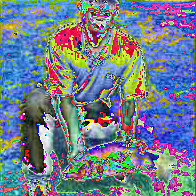

In [ ]:
rgb(image)

In [ ]:
two_images = torch.stack([image]*2)
two_images

tensor[2, 3, 196, 196] n=230496 x∈[-2.118, 2.640] μ=-0.388 σ=1.073

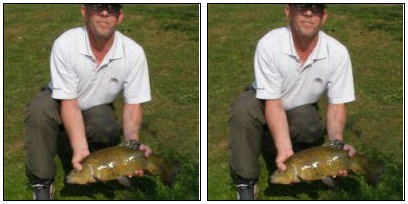

In [ ]:
in_stats = (    (0.485, 0.456, 0.406),  # Mean
                (0.229, 0.224, 0.225) ) # std
rgb(two_images, denorm=in_stats)

In [ ]:
# Make 8 images with progressively higher brightness and stack them 2x2x2.
eight_images = (torch.stack([image]*8) + torch.linspace(-2, 2, 8)[:,None,None,None])
eight_images = (eight_images
                    .mul(torch.tensor(in_stats[1])[:,None,None])
                    .add(torch.tensor(in_stats[0])[:,None,None])
                    .clamp(0,1)
                    .view(2,2,2,3,196,196)
)
eight_images

tensor[2, 2, 2, 3, 196, 196] n=921984 x∈[0., 1.000] μ=0.382 σ=0.319

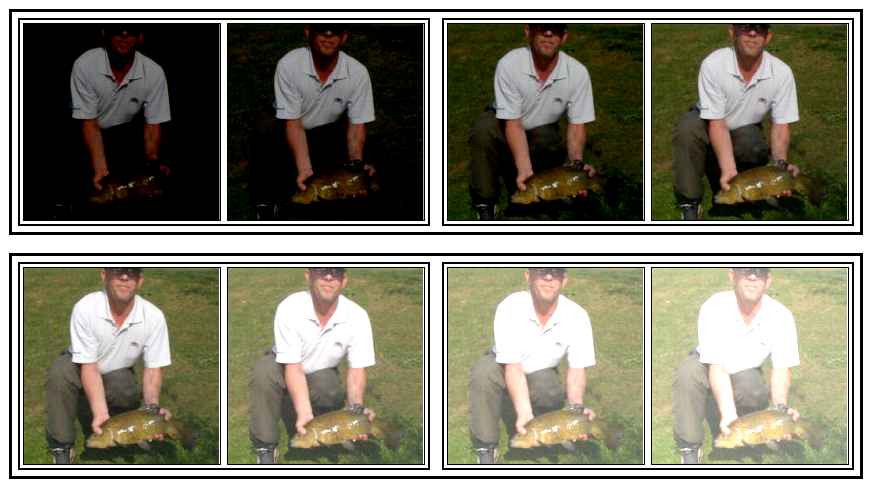

In [ ]:
rgb(eight_images)

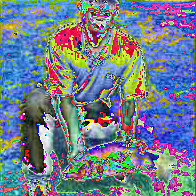

In [ ]:
# You can do channel-last too:
rgb(image.permute(1, 2, 0), cl=True)

before allocation: torch.cuda.memory_allocated()=0
after allocation: torch.cuda.memory_allocated()=786432


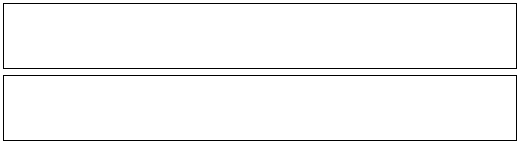

after rgb: torch.cuda.memory_allocated()=786432
after cleanup: torch.cuda.memory_allocated()=0


In [ ]:
# |hide
if torch.cuda.is_available():
    cudamem = torch.cuda.memory_allocated()
    print(f"before allocation: {torch.cuda.memory_allocated()=}")
    numbers = torch.ones((2,3, 64, 512), device="cuda")
    torch.cuda.synchronize()
    print(f"after allocation: {torch.cuda.memory_allocated()=}")
    display(rgb(numbers))
    print(f"after rgb: {torch.cuda.memory_allocated()=}")
   
    del numbers
    # torch.cuda.memory.empty_cache()

    print(f"after cleanup: {torch.cuda.memory_allocated()=}")
    test_eq(cudamem >= torch.cuda.memory_allocated(), True)

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()